<a href="https://colab.research.google.com/github/cristinaluna/ga-based_mapfusion/blob/main/MapFusionUsingGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Map Fusion using GA

## Genetic Algorithms


## Simple method using overlap function


	 CASE 1 

 Generated maps

Stopping early due to threshold at generation 30 with fitness 0.8256
Final Generation 30: Best fitness = 0.8256
Best parameters (tx, ty, theta) (Generated Maps): [1.70111290e+02 2.49182788e+02 9.94429972e-02]
Best parameters: [1.70111290e+02 2.49182788e+02 9.94429972e-02]
Fused map: (899, 820)


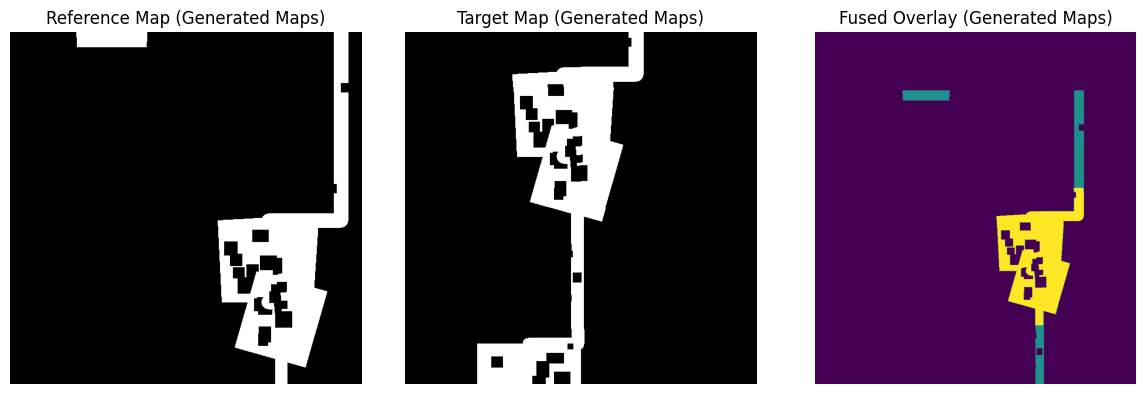


	 CASE 2 

 Real Robot Maps 1



TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [1]:
'''

Map fusion using GA algorithm


Authors: C. Luna, E. Ruiz, P. López
Maintainer: @cristinaluna

'''


import numpy as np
import random
import cv2 as cv
from scipy.ndimage import rotate, sobel, binary_dilation
from scipy.signal import correlate2d
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
import pandas as pd

class GeneticMapFusion:
    def __init__(self, ref_map, target_map, map_name = "", max_generations = 100, pop_size=100, generations=30,
                convergence_generations = 5, mutation_std=(4, 4, 4), elite_size=3, selection_pool=10):
        self.ref_map = ref_map
        self.target_map = target_map
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_std = np.array(mutation_std)
        self.elite_size = elite_size
        self.selection_pool = selection_pool
        self.max_generations = max_generations
        self.fitness_log = pd.DataFrame()
        self.map_name = map_name
        self.convergence_generations = convergence_generations

    def edge_weighted_iou(self, ref, target):
        # Edge dilatation using sobel
        ref_processed = binary_dilation(ref.astype(bool))
        target_processed = binary_dilation(target.astype(bool))

        ref_edges = sobel(ref_processed.astype(float)).astype(bool)
        target_edges = sobel(target_processed.astype(float)).astype(bool)

        intersection = np.logical_and(ref_edges, target_edges).sum()
        union = np.logical_or(ref_edges, target_edges).sum()

        return intersection / union if union > 0 else 0

    def evaluate_fitness(self, individual): # using ncc instead of IoU since it is more robust for non-fully-coincident maps
        tx, ty, theta = individual
        rotated = rotate(self.target_map, theta, reshape=False, order=1, mode='constant', cval=0)

        canvas_h = self.ref_map.shape[0] * 3
        canvas_w = self.ref_map.shape[1] * 3
        ref_canvas = np.zeros((canvas_h, canvas_w), dtype=np.uint8)
        target_canvas = np.zeros_like(ref_canvas)

        center_y, center_x = canvas_h // 2, canvas_w // 2

        y_ref = center_y - self.ref_map.shape[0] // 2
        x_ref = center_x - self.ref_map.shape[1] // 2
        ref_canvas[y_ref:y_ref + self.ref_map.shape[0], x_ref:x_ref + self.ref_map.shape[1]] = self.ref_map

        y_shift = center_y - rotated.shape[0] // 2 + int(round(ty))
        x_shift = center_x - rotated.shape[1] // 2 + int(round(tx))

        y_start = np.clip(y_shift, 0, canvas_h)
        x_start = np.clip(x_shift, 0, canvas_w)
        y_end = np.clip(y_shift + rotated.shape[0], 0, canvas_h)
        x_end = np.clip(x_shift + rotated.shape[1], 0, canvas_w)

        ry1 = np.clip(-y_shift, 0, rotated.shape[0])
        rx1 = np.clip(-x_shift, 0, rotated.shape[1])
        ry2 = ry1 + (y_end - y_start)
        rx2 = rx1 + (x_end - x_start)

        if any(val <= 0 for val in [y_end - y_start, x_end - x_start, ry2 - ry1, rx2 - rx1]):
            return 0

        try:
            target_canvas[y_start:y_end, x_start:x_end] = rotated[ry1:ry2, rx1:rx2]
        except ValueError:
            return 0

        region_ref = ref_canvas[y_start:y_end, x_start:x_end]
        region_target = target_canvas[y_start:y_end, x_start:x_end]

        if region_ref.shape != region_target.shape:
            return 0

        numerator = np.sum(region_ref * region_target)
        denominator = np.sqrt(np.sum(region_ref ** 2) * np.sum(region_target ** 2))
        score = numerator / denominator if denominator > 0 else 0

        if self.generations == 0:
            print(f"Initial fitness score: {score:.4f} for params {individual}")

        return score

    def generate_initial_population(self, tx_range, ty_range, theta_range):
        return [np.array([
            random.uniform(*tx_range),
            random.uniform(*ty_range),
            random.uniform(*theta_range)
        ]) for _ in range(self.pop_size)]

    def evolve(self, tx_range=(-20, 20), ty_range=(-20, 20), theta_range=(-15, 15),
            fitness_threshold=0.80, generations=30, max_generations=100,
            convergence_generations=5, improvement_threshold=1e-4): # check this params!

        if tx_range is None:
            tx_range = (-self.ref_map.shape[1], self.ref_map.shape[1])
        if ty_range is None:
            ty_range = (-self.ref_map.shape[0], self.ref_map.shape[0])

        population = self.generate_initial_population(tx_range, ty_range, theta_range)
        best_fitness = -np.inf
        best_individual = None

        stagnant_count = 0  # Tracks stagnant generations

        for gen in range(max_generations):
            fitness_scores = [self.evaluate_fitness(ind) for ind in population]

            if self.fitness_log.empty:
                self.fitness_log = pd.DataFrame(columns=[f"chrom_{i}" for i in range(len(fitness_scores))])
            self.fitness_log.loc[f'g{gen}'] = fitness_scores

            gen_best = max(fitness_scores)
            gen_best_ind = population[np.argmax(fitness_scores)]

            # Track convergence
            if gen_best > best_fitness + improvement_threshold:
                best_fitness = gen_best
                best_individual = gen_best_ind
                stagnant_count = 0  # Reset counter
            else:
                stagnant_count += 1

            # Print fitness if needed
            # print(f"Generation {gen}: Best fitness = {gen_best:.4f}")

            # Early stop: if fitness threshold met *and* minimum generations passed
            if best_fitness >= fitness_threshold and gen >= generations:
                print(f"Stopping early due to threshold at generation {gen} with fitness {best_fitness:.4f}")
                break

            # Early stop: if no significant improvement for N generations
            if stagnant_count >= convergence_generations and gen >= generations:
                print(f"Stopping early due to convergence at generation {gen} with fitness {best_fitness:.4f}")
                break

            # Elitism + mutation
            sorted_population = [x for _, x in sorted(zip(fitness_scores, population), key=lambda p: -p[0])]
            new_population = sorted_population[:self.elite_size]

            # covariance matrix for mutation
            cov_matrix = np.diag((self.mutation_std * (1 - gen / max_generations))**2)

            while len(new_population) < self.pop_size:
                parents = random.sample(sorted_population[:self.selection_pool], 2)

                child = (parents[0] + parents[1]) / 2
                # Change from random mutation with some normal noise to scale covariance
                # mutation_scale = self.mutation_std * (1 - gen / max_generations)
                # mutation = np.random.normal(loc=0, scale=mutation_scale)

                # Mutate with multivariate normal
                mutation = np.random.multivariate_normal(mean=np.zeros(3), cov=cov_matrix)

                # Occasionally add stronger mutations
                if gen % 5 == 0 and random.random() < 0.3:
                    mutation += np.random.multivariate_normal(mean=np.zeros(3), cov=np.diag((self.mutation_std * 0.5)**2))

                # Occasionally mutate a single parameter more
                if random.random() < 0.1:
                    param_idx = np.random.randint(0, 3)
                    mutation[param_idx] += np.random.normal(loc=0, scale=self.mutation_std[param_idx] * 2)

                child += mutation
                new_population.append(child)

            population = new_population

        # logging
        filename = f"ga_{self.map_name}_pop{self.pop_size}_gen{self.generations}.csv"
        self.fitness_log.to_csv(filename, index=True)

        print(f"Final Generation {gen}: Best fitness = {best_fitness:.4f}")
        return best_individual


    def fuse_maps_aligned(self, best_params):
        # Fuse maps using the best transformation parameters found
        tx, ty, theta = best_params
        rotated = rotate(self.target_map, theta, reshape=False, order=1, mode='constant', cval=0)

        ref_h, ref_w = self.ref_map.shape
        rot_h, rot_w = rotated.shape

        # Create canvas large enough to contain both maps
        canvas_h = max(ref_h, rot_h + abs(int(ty))) + 50
        canvas_w = max(ref_w, rot_w + abs(int(tx))) + 50
        canvas = np.zeros((canvas_h, canvas_w), dtype=np.uint8)

        # Place reference map
        y_offset = canvas_h // 2 - ref_h // 2
        x_offset = canvas_w // 2 - ref_w // 2
        canvas[y_offset:y_offset + ref_h, x_offset:x_offset + ref_w] = self.ref_map

        # Place transformed target map
        shifted_y = y_offset + int(round(ty))
        shifted_x = x_offset + int(round(tx))
        target_canvas = np.zeros_like(canvas)

        y_start = np.clip(shifted_y, 0, canvas_h)
        x_start = np.clip(shifted_x, 0, canvas_w)
        y_end = np.clip(shifted_y + rot_h, 0, canvas_h)
        x_end = np.clip(shifted_x + rot_w, 0, canvas_w)

        crop_y1 = np.clip(-shifted_y, 0, rot_h)
        crop_x1 = np.clip(-shifted_x, 0, rot_w)
        crop_y2 = crop_y1 + (y_end - y_start)
        crop_x2 = crop_x1 + (x_end - x_start)

        if (crop_y2 > crop_y1) and (crop_x2 > crop_x1):
            try:
                target_canvas[y_start:y_end, x_start:x_end] = rotated[crop_y1:crop_y2, crop_x1:crop_x2]
            except ValueError:
                pass

        fused_map = np.where((canvas == 1) & (target_canvas == 1), 1,
                     np.where((canvas == 1) | (target_canvas == 1), 0.5, 0))

        return fused_map, canvas, target_canvas

# ----------------- COMPARISON WITH OTHER METHODS --------

    # aligning using cross correlation
    def align_with_cross_correlation(self):
        correlation = correlate2d(self.ref_map, self.target_map, mode='full')
        max_idx = np.unravel_index(np.argmax(correlation), correlation.shape)
        shift_y = max_idx[0] - self.target_map.shape[0] + 1
        shift_x = max_idx[1] - self.target_map.shape[1] + 1

        return np.array([shift_x, shift_y, 0])

    # aligning using ORB descriptors and RANSAC
    def align_with_ransac(self):
        kp_detector = cv.ORB_create(500)
        matcher = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

        # ORB needs uint8 images
        ref_uint8 = (self.ref_map * 255).astype(np.uint8)
        target_uint8 = (self.target_map * 255).astype(np.uint8)

        kp1, des1 = kp_detector.detectAndCompute(ref_uint8, None)
        kp2, des2 = kp_detector.detectAndCompute(target_uint8, None)

        if des1 is None or des2 is None or len(kp1) < 5 or len(kp2) < 5:
            print("Insufficient keypoints for RANSAC.")
            return np.array([0, 0, 0])

        matches = matcher.match(des1, des2)
        if len(matches) < 4:
            print("Not enough matches for RANSAC.")
            return np.array([0, 0, 0])

        src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)

        M, inliers = cv.estimateAffinePartial2D(src_pts, dst_pts, method=cv.RANSAC)
        if M is None:
            return np.array([0, 0, 0])

        tx = M[0, 2]
        ty = M[1, 2]
        angle = np.arctan2(M[1, 0], M[0, 0]) * 180 / np.pi  # radians to degrees

        return np.array([tx, ty, angle])



# ----------------- MAPS! ------------------


def draw_room(img, x, y, w, h, filled=True):
    shape_type = random.choice(['rect', 'rotated_rect', 'irregular'])
    if shape_type == 'rect':
        cv.rectangle(img, (x, y), (x + w, y + h), 255, -1 if filled else 2)
    elif shape_type == 'rotated_rect':
        angle = random.uniform(-30, 30)
        rect = ((x + w // 2, y + h // 2), (w, h), angle)
        box = cv.boxPoints(rect).astype(int)
        cv.drawContours(img, [box], 0, 255, -1)
    elif shape_type == 'irregular':
        pts = np.array([
            [x, y],
            [x + w, y + random.randint(-10, 10)],
            [x + w + random.randint(-10, 10), y + h],
            [x + random.randint(-10, 10), y + h + random.randint(-10, 10)]
        ])
        cv.fillPoly(img, [pts], 255)

    # Larger obstacles (more and bigger)
    for _ in range(random.randint(5, 10)):
        ox = x + random.randint(10, max(10, w - 40))
        oy = y + random.randint(10, max(10, h - 40))
        ow = random.randint(15, min(30, w - (ox - x)))
        oh = random.randint(15, min(30, h - (oy - y)))
        cv.rectangle(img, (ox, oy), (ox + ow, oy + oh), 0, -1)


def connect_rooms_with_corridor(img, room1, room2):
    x1, y1, w1, h1 = room1
    x2, y2, w2, h2 = room2

    edges1 = [
        (x1 + w1 // 2, y1),           # top center
        (x1 + w1 // 2, y1 + h1),      # bottom center
        (x1, y1 + h1 // 2),           # left center
        (x1 + w1, y1 + h1 // 2)       # right center
    ]
    edges2 = [
        (x2 + w2 // 2, y2),
        (x2 + w2 // 2, y2 + h2),
        (x2, y2 + h2 // 2),
        (x2 + w2, y2 + h2 // 2)
    ]

    min_dist = float('inf')
    best_pair = (edges1[0], edges2[0])
    for e1 in edges1:
        for e2 in edges2:
            dist = (e1[0] - e2[0]) ** 2 + (e1[1] - e2[1]) ** 2
            if dist < min_dist:
                min_dist = dist
                best_pair = (e1, e2)

    (x_start, y_start), (x_end, y_end) = best_pair

    thickness = random.randint(15, 25)

    if random.random() > 0.5:
        mid_point = (x_end, y_start)
    else:
        mid_point = (x_start, y_end)

    cv.line(img, (x_start, y_start), mid_point, 255, thickness)
    cv.line(img, mid_point, (x_end, y_end), 255, thickness)

    for _ in range(random.randint(6, 10)):
        tx = random.randint(min(x_start, x_end), max(x_start, x_end))
        ty = random.randint(min(y_start, y_end), max(y_start, y_end))
        ow = random.randint(10, 20)
        oh = random.randint(10, 20)
        cv.rectangle(img, (tx, ty), (tx + ow, ty + oh), 0, -1)


def generate_overlapping_submaps(global_size=(1200, 1200), submap_size=(600, 600),
                                 overlap_ratio=0.6, num_rooms=6, seed=None,
                                 apply_rotation=True, max_rotation=5,
                                 apply_noise=True, noise_std=0.02):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    H, W = global_size
    sub_h, sub_w = submap_size

    base = np.zeros((H, W), dtype=np.uint8)
    rooms = []

    for _ in range(num_rooms):
        rw = random.randint(120, 180)  # bigger rooms
        rh = random.randint(120, 180)
        x = random.randint(0, W - rw - 1)
        y = random.randint(0, H - rh - 1)
        draw_room(base, x, y, rw, rh)
        rooms.append((x, y, rw, rh))

    for i in range(len(rooms) - 1):
        connect_rooms_with_corridor(base, rooms[i], rooms[i + 1])

    overlap_px_h = int(sub_h * overlap_ratio)
    overlap_px_w = int(sub_w * overlap_ratio)

    margin = 30
    max_y = H - sub_h - margin
    max_x = W - sub_w - margin

    y1 = random.randint(margin, max_y)
    x1 = random.randint(margin, max_x)

    y2 = y1 + sub_h - overlap_px_h + random.randint(-15, 15)
    x2 = x1 + sub_w - overlap_px_w + random.randint(-15, 15)

    y2 = np.clip(y2, margin, max_y)
    x2 = np.clip(x2, margin, max_x)

    submap1 = base[y1:y1 + sub_h, x1:x1 + sub_w].copy()
    submap2 = base[y2:y2 + sub_h, x2:x2 + sub_w].copy()

    if apply_rotation:
        angle = random.uniform(-max_rotation, max_rotation)  # subtle rotation
        submap2 = rotate(submap2, angle, reshape=False, order=1, mode='constant', cval=0)
        submap2 = (submap2 > 0.5).astype(np.uint8)

    if apply_noise:
        noise = np.random.normal(0, noise_std, submap2.shape)
        submap2 = np.clip(submap2.astype(np.float32) + noise, 0, 1)
        submap2 = (submap2 > 0.5).astype(np.uint8)

    return (submap1 > 0).astype(np.uint8), (submap2 > 0).astype(np.uint8)


# ------------------------------ RUN! ---------------------------------------------

def run_fusion(ref_map, target_map, max_generations, map_name, title_suffix=","):

    plt.close('all')
    gmf = GeneticMapFusion(ref_map, target_map, map_name, max_generations, pop_size=100, generations=30, mutation_std=(4, 4, 4))
    w, h = ref_map.shape[1], ref_map.shape[0]
    best_params = gmf.evolve(tx_range=(-w, w), ty_range=(-h, h), theta_range=(-15, 15))
    print(f"Best parameters (tx, ty, theta) {title_suffix}:", best_params)

    fused_map, ref_canvas, target_canvas = gmf.fuse_maps_aligned(best_params)

    plt.figure(figsize=(12, 4))

    # 1. Reference Map
    plt.subplot(1, 3, 1)
    plt.title(f"Reference Map {title_suffix}")
    plt.imshow(ref_map, cmap='gray')
    plt.axis('off')

    # 2. Target Map
    plt.subplot(1, 3, 2)
    plt.title(f"Target Map {title_suffix}")
    plt.imshow(target_map, cmap='gray')
    plt.axis('off')

    # 3. Fused Overlay (RGB)
    plt.subplot(1, 3, 3)
    plt.title(f"Fused Overlay {title_suffix}")

    print(f"Best parameters: {best_params}")
    print(f"Fused map: {fused_map.shape}")

    plt.imshow(fused_map)
    plt.axis('off')
    plt.tight_layout()
    plt.show(block=False)
    plt.close('all')

    if title_suffix == "(Generatd Maps)":
        print("\n Quite good, let's continue with the comparison!\n") # yes, it's support and debug

        # now with cross crorrelation and orb+ransac
        cc_params = gmf.align_with_cross_correlation()
        print(f"Cross-Correlation params {title_suffix}:", cc_params)

        ransac_params = gmf.align_with_ransac()
        print(f"RANSAC params {title_suffix}:", ransac_params)

        fused_cc, _, _ = gmf.fuse_maps_aligned(cc_params)
        fused_ransac, _, _ = gmf.fuse_maps_aligned(ransac_params)

        plt.figure(figsize=(12, 4))

        # Normalise maps
        def safe_display(img, title):
            if img.ndim == 3:
                img = img.astype(np.float32)
                if img.max() > 1.0:
                    img /= 255.0
                plt.imshow(img)
            else:
                plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')

        plt.subplot(1, 3, 1)
        safe_display(fused_map, f"Genetic Fusion {title_suffix}")

        plt.subplot(1, 3, 2)
        safe_display(fused_cc, f"Cross-Correlation Fusion {title_suffix}")

        plt.subplot(1, 3, 3)
        safe_display(fused_ransac, f"RANSAC Fusion {title_suffix}")

        plt.tight_layout()
        plt.show()


# ----------------- USAGE EXAMPLE ------------------
if __name__ == "__main__":

    print("\n\t CASE 1 \n\n Generated maps\n")
    # Case 1: using generated maps
    ref_map, target_map = generate_overlapping_submaps()
    run_fusion(ref_map, target_map, 100, "random", title_suffix="(Generated Maps)")


    print("\n\t CASE 2 \n\n Real Robot Maps 1\n")
    # Case 2: using real robot maps general_1_1.png y general_1_2.png
    ref_map = cv.imread("general_1_1.png", cv.IMREAD_GRAYSCALE)
    target_map = cv.imread("general_1_2.png", cv.IMREAD_GRAYSCALE)

    ref_map = (ref_map > 127).astype(np.uint8)
    target_map = (target_map > 127).astype(np.uint8)

    run_fusion(ref_map, target_map, 100, "real_robot_1", title_suffix="(General 1)")

    print("\n\t CASE 3 \n\n Real Robot Maps 2\n")
    # Case 3: using real robot maps general_2_1.png y general_2_2.png

    ref_map = cv.imread("general_2_1.png", cv.IMREAD_GRAYSCALE)
    target_map = cv.imread("general_2_2.png", cv.IMREAD_GRAYSCALE)

    ref_map = (ref_map > 127).astype(np.uint8)
    target_map = (target_map > 127).astype(np.uint8)

    run_fusion(ref_map, target_map, 40, "real_robot_2", title_suffix="(General 2)")

## PARALELISATION

In [ ]:
# This Python code generates a block diagram for the VHDL parallelization approach.
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(12, 6))

# Define block diagram elements
blocks = [
    {"label": "Input\nMaps", "xy": (0.1, 0.5)},
    {"label": "Population\nInit", "xy": (0.25, 0.5)},
    {"label": "Parallel\nFitness Eval", "xy": (0.45, 0.7)},
    {"label": "Selection\n+ Elitism", "xy": (0.65, 0.7)},
    {"label": "Crossover\n+ Mutation", "xy": (0.65, 0.3)},
    {"label": "Stop\nCondition", "xy": (0.85, 0.5)},
    {"label": "Output:\nBest Params", "xy": (1.0, 0.5)}
]

# Draw rectangles and annotations
for block in blocks:
    rect = patches.FancyBboxPatch((block["xy"][0]-0.05, block["xy"][1]-0.08), 0.1, 0.16,
                                   boxstyle="round,pad=0.02", edgecolor='black', facecolor='lightblue')
    ax.add_patch(rect)
    ax.text(block["xy"][0], block["xy"][1], block["label"], ha='center', va='center', fontsize=10)

# Draw arrows between blocks
connections = [
    ((0.15, 0.5), (0.2, 0.5)),
    ((0.3, 0.5), (0.4, 0.7)),
    ((0.5, 0.7), (0.6, 0.7)),
    ((0.7, 0.7), (0.75, 0.5)),
    ((0.75, 0.5), (0.7, 0.3)),
    ((0.7, 0.3), (0.6, 0.3)),
    ((0.6, 0.3), (0.4, 0.7)),
    ((0.75, 0.5), (0.8, 0.5)),
    ((0.9, 0.5), (0.95, 0.5))
]

for start, end in connections:
    ax.annotate('', xy=end, xytext=start,
                arrowprops=dict(arrowstyle='->', lw=1.5, color='black'))

ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.title("Parallel Genetic Map Fusion Algorithm (FPGA VHDL Conceptual Diagram)", fontsize=12)
plt.show()


# Generate 100 hundred sets of maps!

In [2]:
import os
import imageio
import random

def save_map_pair(ref_map, target_map, index, output_dir="maps"):
    map_dir = os.path.join(output_dir, f"synthetic_map_{index}")
    os.makedirs(map_dir, exist_ok=True)

    ref_path = os.path.join(map_dir, f"synthetic_map_{index}_1.png")
    target_path = os.path.join(map_dir, f"synthetic_map_{index}_2.png")

    if ref_map.sum() == 0 or target_map.sum() == 0:
        print(f"[WARN] Map {index} was empty, skipping.")
        return False

    imageio.imwrite(ref_path, (ref_map * 255).astype(np.uint8))
    imageio.imwrite(target_path, (target_map * 255).astype(np.uint8))
    return True


def generate_and_save_n_maps(n=100, output_dir="maps"):
    os.makedirs(output_dir, exist_ok=True)
    count = 0
    trials = 0
    while count < n and trials < n * 2:
        overlap = random.uniform(0.1, 0.9)
        ref, tgt = generate_overlapping_submaps(overlap_ratio=overlap, seed=trials)
        success = save_map_pair(ref, tgt, count, output_dir)
        if success:
            print(f"[OK] synthetic_map_{count} saved (overlap={overlap:.2f})")
            count += 1
        trials += 1

generate_and_save_n_maps(100)

[OK] synthetic_map_0 saved (overlap=0.38)
[WARN] Map 1 was empty, skipping.
[OK] synthetic_map_1 saved (overlap=0.56)
[OK] synthetic_map_2 saved (overlap=0.59)
[OK] synthetic_map_3 saved (overlap=0.41)
[OK] synthetic_map_4 saved (overlap=0.48)
[OK] synthetic_map_5 saved (overlap=0.14)
[OK] synthetic_map_6 saved (overlap=0.38)
[OK] synthetic_map_7 saved (overlap=0.42)
[OK] synthetic_map_8 saved (overlap=0.60)
[OK] synthetic_map_9 saved (overlap=0.82)
[OK] synthetic_map_10 saved (overlap=0.27)
[OK] synthetic_map_11 saved (overlap=0.89)
[OK] synthetic_map_12 saved (overlap=0.89)
[OK] synthetic_map_13 saved (overlap=0.57)
[OK] synthetic_map_14 saved (overlap=0.70)
[OK] synthetic_map_15 saved (overlap=0.87)
[OK] synthetic_map_16 saved (overlap=0.26)
[OK] synthetic_map_17 saved (overlap=0.82)
[OK] synthetic_map_18 saved (overlap=0.53)
[OK] synthetic_map_19 saved (overlap=0.84)
[OK] synthetic_map_20 saved (overlap=0.17)
[OK] synthetic_map_21 saved (overlap=0.48)
[OK] synthetic_map_22 saved (o

# RUN ALL TEST ON 100 MAPS!

In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

def run_on_synthetic_dataset(map_dir="maps", output_csv="fusion_summary.csv"):
    summary = []
    index = 0

    while True:
        map_subdir = os.path.join(map_dir, f"synthetic_map_{index}")
        ref_path = os.path.join(map_subdir, f"synthetic_map_{index}_1.png")
        tgt_path = os.path.join(map_subdir, f"synthetic_map_{index}_2.png")
        if not os.path.exists(ref_path) or not os.path.exists(tgt_path):
            break

        print(f"\nProcessing synthetic_map_{index}")

        ref_map = cv.imread(ref_path, cv.IMREAD_GRAYSCALE)
        target_map = cv.imread(tgt_path, cv.IMREAD_GRAYSCALE)

        if ref_map is None or target_map is None or ref_map.sum() == 0 or target_map.sum() == 0:
            print(f"[SKIP] synthetic_map_{index} is empty or unreadable.")
            index += 1
            continue

        ref_map = (ref_map > 127).astype(np.uint8)
        target_map = (target_map > 127).astype(np.uint8)

        plt.close('all')
        gmf = GeneticMapFusion(ref_map, target_map, f"synthetic_map_{index}", max_generations=100, pop_size=100, generations=30, mutation_std=(4, 4, 4))
        best_params = gmf.evolve(tx_range=(-ref_map.shape[1], ref_map.shape[1]),
                                 ty_range=(-ref_map.shape[0], ref_map.shape[0]),
                                 theta_range=(-15, 15))

        fused_map, _, _ = gmf.fuse_maps_aligned(best_params)

        # -------------------- Show fusion result --------------------
        plt.figure(figsize=(12, 4))

        # Reference Map
        plt.subplot(1, 3, 1)
        plt.title(f"Ref Map {index}")
        plt.imshow(ref_map, cmap='gray')
        plt.axis('off')

        # Target Map
        plt.subplot(1, 3, 2)
        plt.title(f"Target Map {index}")
        plt.imshow(target_map, cmap='gray')
        plt.axis('off')

        # Fused Overlay
        plt.subplot(1, 3, 3)
        plt.title(f"Fused Overlay {index}")
        plt.imshow(fused_map)
        plt.axis('off')

        plt.tight_layout()
        plt.show(block=True)

        fusion_img_path = os.path.join(map_subdir, f"synthetic_map_{index}_fusion.png")
        cv.imwrite(fusion_img_path, cv.cvtColor((fused_map * 255).astype(np.uint8), cv.COLOR_RGB2BGR))
        plt.close()

        # -------------------- Extract fitness data ----------------------
        fitness_matrix = gmf.fitness_log.to_numpy().flatten()
        fitness_matrix = fitness_matrix[~np.isnan(fitness_matrix)]  # remove NaNs if present

        if fitness_matrix.size > 0:
            max_score = float(np.max(fitness_matrix))
            min_score = float(np.min(fitness_matrix))
            mean_score = float(np.mean(fitness_matrix))
            median_score = float(np.median(fitness_matrix))
            final_score = float(np.max(gmf.fitness_log.iloc[-1]))  # Best in last generation
            num_generations = gmf.fitness_log.shape[0]
        else:
            print("[WARN] Empty fitness log — using -1 values.")
            max_score = min_score = mean_score = median_score = final_score = -1
            num_generations = -1

        # -------------------- Ask for manual evaluation --------------------
        user_input = input(f"Was synthetic_map_{index} fusion successful? (Y/N): ").strip().upper()
        success_flag = "Y" if user_input == "Y" else "N"

        # -------------------- Save per-map CSV --------------------
        per_map_csv = os.path.join(map_subdir, f"synthetic_map_{index}.csv")
        with open(per_map_csv, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["max", "min", "mean", "median", "num_generations", "final_score", "successful"])
            writer.writerow([max_score, min_score, mean_score, median_score, num_generations, final_score, success_flag])

        # -------------------- Add to summary --------------------
        summary.append([index, max_score, min_score, mean_score, median_score, num_generations, final_score, success_flag])
        index += 1

    # -------------------- Save summary CSV --------------------
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["index", "max", "min", "mean", "median", "num_generations", "final_score", "successful"])
        writer.writerows(summary)

    print(f"\n✅ Summary saved to '{output_csv}' with {len(summary)} entries.")


if __name__ == "__main__":
    run_on_synthetic_dataset(map_dir="maps", output_csv="fusion_summary.csv")


Processing synthetic_map_0
